## Comparison of ways to calculate the IDD
In this notebook we compare the various ways the IDDs per course can be calculated from the microdata (see the [previous notebook](3-CalculateIDDs.ipynb))

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

Variables with `inep` in them are calculated according to the (erroneous) INEP methodology, which take the "random intercept" model and averages the residues. The `intercept` IDDs are calculated by taking the "random intercept" model and taking the intercepts estimated by the model as the IDD. The `noranef` IDDs ("no random effects") are calculated by taking again the same "random intercept" model, but this time average different residues. We now calculate residues against the overall best linear fit, and again average them to get to the IDD of the course. 

In [34]:
import os

def get_areas(ano,Nmin):
    files = os.listdir('data/calculated/')
    areas = []
    for fn in files:
        name = fn.split('.')[0]
        parts = name.split('-')
        if len(parts) < 6:
            continue
        fano,area,nmin = parts[2],parts[3],parts[5]
        if str(ano) == fano and str(Nmin) == nmin:
            areas.append(area)
    return set(areas)
#get_areas(files,2014,50)

In [127]:
def mergeidd(df1,df2,on=['curso'],validate='1:1',newcols={}):
    ''
    df = pd.merge(df1,df2,on=on,how='inner',validate=validate)
    df.rename(columns=newcols,inplace=True)
    #print("courses: ",len(df))
    return df

In [170]:
#areas = pd.read_csv('data/calculated/areas14-17.csv')
def read_idds(Nmin):
    areas = get_areas(2014,Nmin) & get_areas(2017,Nmin)
    idd_calc_inep17 = pd.concat([pd.read_csv('data/calculated/idd-'+'ml-'+'2017-'+str(area)+'-nmin-'+str(Nmin)+'.csv') for area in areas])
    idd_calc_inep14 = pd.concat([pd.read_csv('data/calculated/idd-'+'ml-'+'2014-'+str(area)+'-nmin-'+str(Nmin)+'.csv') for area in areas])

    idd_calc_intercept17 = pd.concat([pd.read_csv('data/calculated/idd-'+'intercept-'+'2017-'+str(area)+'-nmin-'+str(Nmin)+'.csv') for area in areas])
    idd_calc_intercept14 = pd.concat([pd.read_csv('data/calculated/idd-'+'intercept-'+'2014-'+str(area)+'-nmin-'+str(Nmin)+'.csv') for area in areas])

    idd_calc_noranef17 = pd.concat([pd.read_csv('data/calculated/idd-'+'noranef-'+'2017-'+str(area)+'-nmin-'+str(Nmin)+'.csv') for area in areas])
    idd_calc_noranef14 = pd.concat([pd.read_csv('data/calculated/idd-'+'noranef-'+'2014-'+str(area)+'-nmin-'+str(Nmin)+'.csv') for area in areas])

    df = mergeidd(idd_calc_intercept17,idd_calc_noranef17,newcols={'idd_x':'idd_intercept17','idd_y':'idd_noranef17'})
    df = mergeidd(df,idd_calc_inep17,newcols={'idd':'idd_inep17'})
    df = mergeidd(df,idd_calc_inep14,newcols={'idd':'idd_inep14'})
    df = mergeidd(df,idd_calc_intercept14,newcols={'idd':'idd_intercept14','adm_x':'admi'})
    df = mergeidd(df,idd_calc_noranef14,newcols={'idd':'idd_noranef14','adm_x':'adm'})
    df = df[['idd_intercept17','idd_noranef17','idd_inep17','idd_intercept14','idd_noranef14','idd_inep14','adm']]
    return df

Let's calculate all the correlations.

In [218]:
df = read_idds(2)
df.corr()

,idd_intercept17,idd_noranef17,idd_inep17,idd_intercept14,idd_noranef14,idd_inep14
idd_intercept17,1.000000,0.937345,0.605979,0.356012,0.347425,0.253487
idd_noranef17,0.937345,1.000000,0.813195,0.326827,0.334661,0.260442
idd_inep17,0.605979,0.813195,1.000000,0.226530,0.249325,0.230831
idd_intercept14,0.356012,0.326827,0.226530,1.000000,0.939220,0.641909
idd_noranef14,0.347425,0.334661,0.249325,0.939220,1.000000,0.818701
idd_inep14,0.253487,0.260442,0.230831,0.641909,0.818701,1.000000


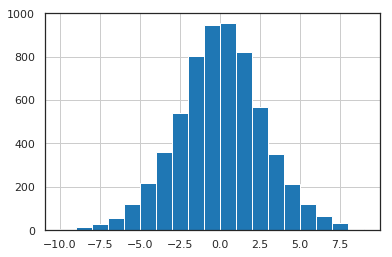

In [219]:
df.idd_intercept17.hist(bins=range(-10,10))

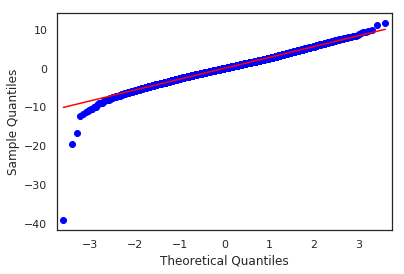

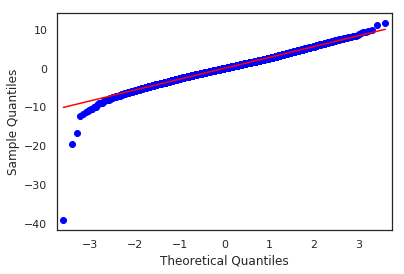

In [220]:
from statsmodels.graphics.gofplots import qqplot
qqplot(df.idd_intercept17,line='r')

Note que high correlation between `intercept` and `noranef`, showing that these methods are very similar. The correlations between 2014 and 2017 of these better methods of calculating IDD and the INEP one increases from 0.23 to 0.35. 

How do the correlations between measures in 2014 and 2017 stabilize as we only estimate the model taking into account courses with some mininum number of ENADE participants?

In [128]:
corrs = pd.DataFrame(columns=['N','Nc','inep','intercept','noranef'])
for N in[5,10,15,20,30,40,50]:
    df = read_idds(N)
    Nc = len(df)
    inep = df.corr().loc['idd_inep17','idd_inep14']
    intercept = df.corr().loc['idd_intercept17','idd_intercept14']
    noranef = df.corr().loc['idd_noranef17','idd_noranef14']
    corrs.loc[N] = [N,Nc,inep,intercept,noranef]
    corrs.reset_index(drop=True,inplace=True)
corrs

,N,Nc,inep,intercept,noranef
0,5.0,5317.0,0.278621,0.369426,0.364495
1,10.0,3672.0,0.308492,0.395066,0.395203
2,15.0,2449.0,0.355681,0.408360,0.422360
3,20.0,1636.0,0.432484,0.420412,0.426969
4,30.0,794.0,0.544622,0.452741,0.462483
5,40.0,413.0,0.373078,0.417716,0.415819
6,50.0,229.0,0.463480,0.453203,0.461358


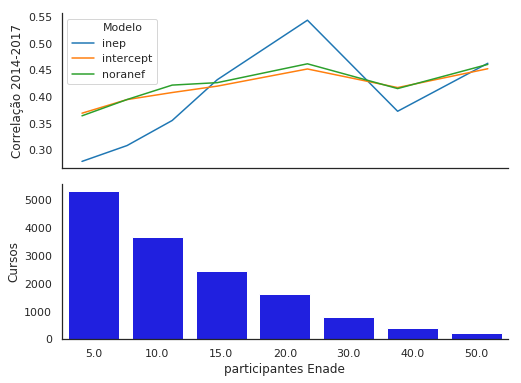

In [160]:
fig,axs = plt.subplots(2,1,figsize=(8,6),sharex=False)
data = pd.melt(corrs,id_vars='N',value_vars=['inep','intercept','noranef'],var_name='Modelo')
sns.set_context('notebook')
ax = axs[0]
sns.lineplot(data=data,x='N',y='value',hue='Modelo',ax=ax)
ax.set_xlabel("")
ax.set_ylabel("Correlação 2014-2017")
ax.set_xticklabels([])
ax = axs[1]
data = pd.melt(corrs,id_vars='N',value_vars=['Nc'])
sns.barplot(data=data,x='N',y='value',color='b',ax=ax)
ax.set_xlabel('participantes Enade')
ax.set_ylabel("Cursos")
plt.subplots_adjust(hspace=0.1)
sns.despine()

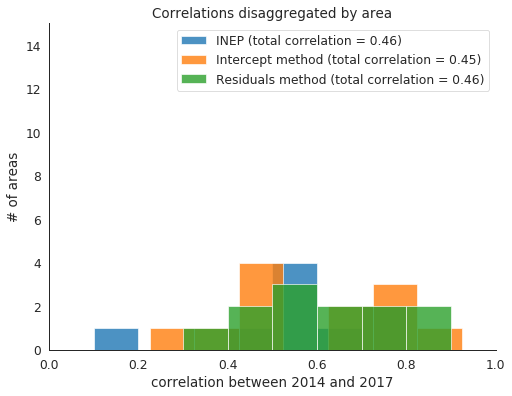

In [221]:
fig = plt.figure(figsize=(8,6))
sns.set_context('paper',font_scale=1.4)
sns.set_style('white')
alpha = 0.8
bins = np.arange(0,1,.1)

def corrfig(methods=['inep','intercept'],savefig=False):
    for method in methods:
        if method == 'inep':
            corr = df_inep[['idd14','idd17']].corr().iloc[0,1]
            corrs = df_inep[['area','idd14','idd17']].groupby('area').corr().iloc[0::2,-1].sort_values()
            corrs.hist(label="INEP (total correlation = {:.2f})".format(corr),alpha=alpha,bins=bins)
        elif method == 'intercept':
            corr = df_intercept[['idd14','idd17']].corr().iloc[0,1]
            corrs = df_intercept[['area','idd14','idd17']].groupby('area').corr().iloc[0::2,-1].sort_values()
            corrs.hist(label="Intercept method (total correlation = {:.2f})".format(corr),alpha=alpha,bins=bins+0.025)
        elif method == 'noranef':
            corr = df_noranef[['idd14','idd17']].corr().iloc[0,1]
            corrs = df_noranef[['area','idd14','idd17']].groupby('area').corr().iloc[0::2,-1].sort_values()
            corrs.hist(label="Residuals method (total correlation = {:.2f})".format(corr),alpha=alpha,bins=bins)
    
    ax = plt.gca()
    ax.set_title("Correlations disaggregated by area")
    ax.set_ylim(0,15)
    ax.set_xlim(0,1)
    ax.set_ylabel("# of areas")
    ax.set_xlabel("correlation between 2014 and 2017")
    ax.grid(False)
    plt.legend()
    sns.despine()
    if savefig:
        for dpi in [50,100,300]:
            fn = 'figs/corrs-compare-14-17-{}.png'.format(dpi)
            plt.savefig(fn,dpi=dpi)

corrfig(['inep','intercept','noranef'],savefig=True)

In [173]:
data[:3]

,idd_intercept17,idd_noranef17,idd_inep17,idd_intercept14,idd_noranef14,idd_inep14,adm
0,0.312396,0.391815,0.079418,-0.121358,-0.228914,0.389274,priv_sfl
1,-0.292872,-0.346285,-0.053413,0.472167,0.868989,0.925510,priv_sfl
2,-0.494141,-0.549786,-0.055645,-0.265127,-0.334237,-0.069110,priv_cfl


/home/ewout/.conda/envs/idd/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


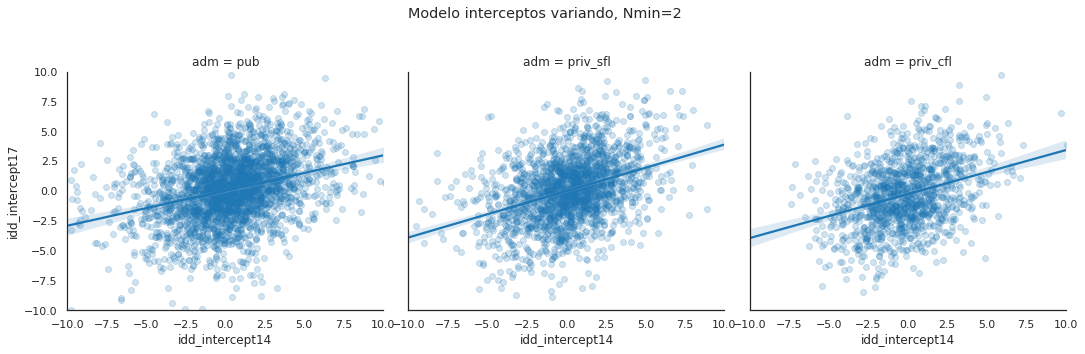

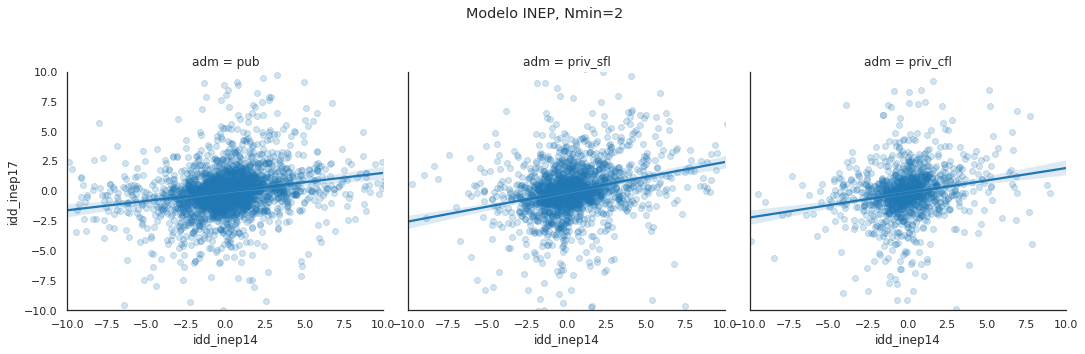

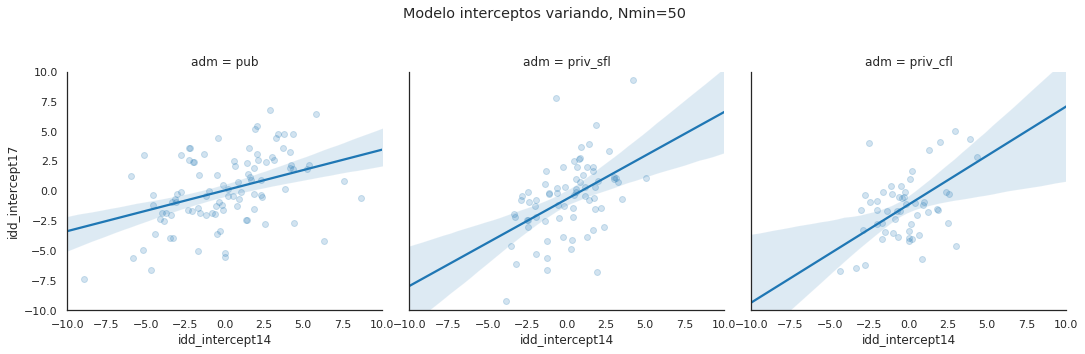

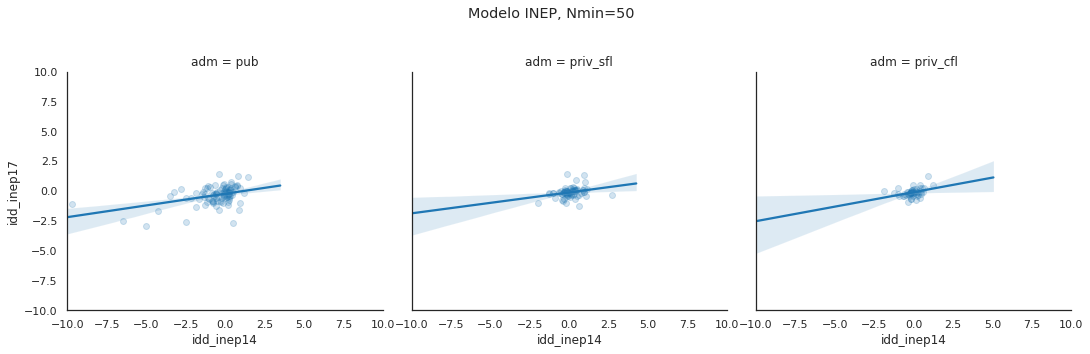

In [217]:
def gencorrfig(Nmin):
    data = read_idds(Nmin)
    sns.set_context('notebook')
    g = sns.lmplot(data = data,x='idd_intercept14',y='idd_intercept17',height=5,col='adm',col_order=['pub','priv_sfl','priv_cfl'],scatter_kws={'alpha':0.2})
    g.set(xlim=(-10,10))
    g.set(ylim=(-10,10))
    g.fig.suptitle("Modelo interceptos variando, Nmin={}".format(Nmin))
    plt.subplots_adjust(top=0.8)
    g = sns.lmplot(data = data,x='idd_inep14',y='idd_inep17',height=5,col='adm',col_order=['pub','priv_sfl','priv_cfl'],scatter_kws={'alpha':0.2})
    g.set(xlim=(-10,10))
    g.set(ylim=(-10,10))
    g.fig.suptitle("Modelo INEP, Nmin={}".format(Nmin))
    plt.subplots_adjust(top=0.8)

gencorrfig(2)
gencorrfig(50)

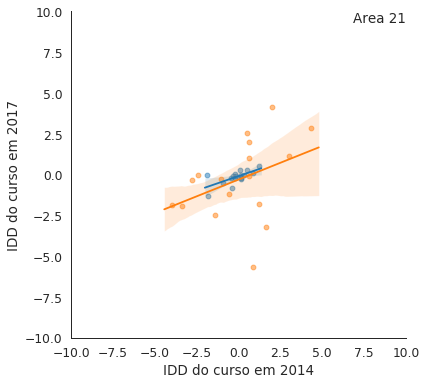

In [71]:
area=21
fig = plt.figure(figsize=(6,6))
sns.regplot(data=df_inep.query("area == @area"),x='idd14',y='idd17',scatter_kws={'alpha':0.5})
sns.regplot(data=df_intercept.query("area == 21"),x='idd14',y='idd17',scatter_kws={'alpha':0.5})
ax = plt.gca()
ax.set_xlim(-10,10)
ax.set_ylim(-10,10)
ax.set_xlabel("IDD do curso em 2014")
ax.set_ylabel("IDD do curso em 2017")
ax.text(1,1,"Area " + str(area),
            horizontalalignment='right',
            verticalalignment='top',transform=ax.transAxes);
sns.despine()

for dpi in [50,300]:
     fn = 'figs/corr-comp-21-14-17-{}.png'.format(dpi)
     plt.savefig(fn,dpi=dpi)

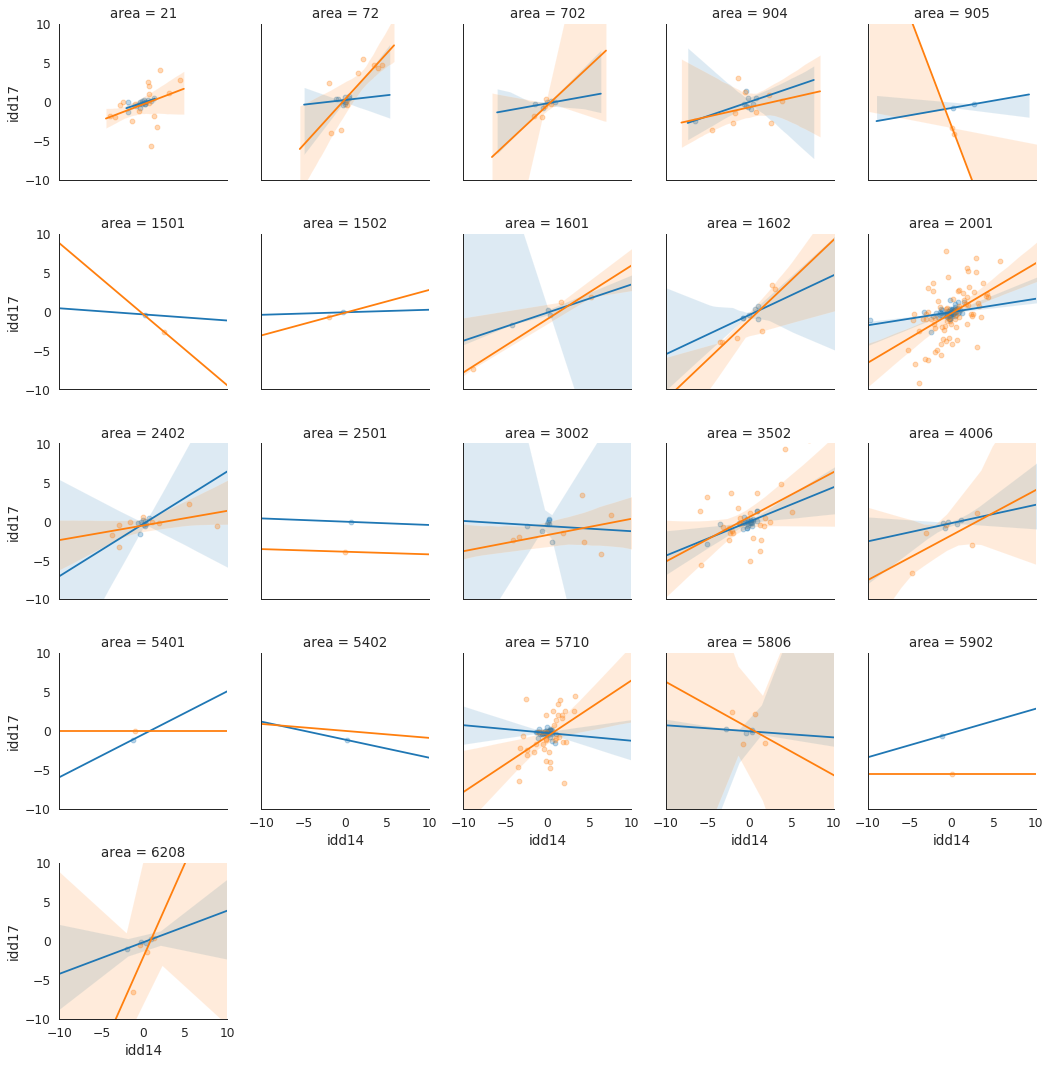

In [72]:
df_inep['method'] = 'inep'
df_intercept['method'] = 'intercept'
df = pd.concat([df_inep,df_intercept])
g = sns.FacetGrid(df,col='area',height=3,col_wrap=5,hue='method')
g.map(sns.regplot,'idd14','idd17',scatter_kws={'alpha':0.3});
g.set(xlim=(-10,10))
g.set(ylim=(-10,10))